In [1]:
import os
import datetime

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from src.model import unet_model
from src.dataset import SegmentationDataset
from src.data_pipeline import SegmentationDataPipeline
from src.data_utils import plot_sample_batch


%load_ext lab_black
%load_ext autoreload
%autoreload 2

2022-10-11 12:17:58.282646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu::/usr/lib/hadoop/lib/native
2022-10-11 12:17:58.282773: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-11 12:17:58.440862: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-11 12:18:03.672733: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu::/usr/lib/hadoop/lib/native
2022-10-11 12:18:03.673894: W tensorflow

## Load Test Set

In [2]:
IMG_SHAPE = (256, 1600)
BATCH_SIZE = 8
ANNOTATIONS_PATH = "../data/train.csv"
TRAIN_IMG_PATH = "../data/train_images/"

# instantiate dataset and pipelne
sd = SegmentationDataset(
    label_file=ANNOTATIONS_PATH,
    img_dir_path=TRAIN_IMG_PATH,
    img_shape=IMG_SHAPE,
)

# create train/test & x/y splits
train_imgs, test_imgs = sd.get_train_test_split(test_size=0.2)

# small sample
train_imgs = train_imgs[:200]
test_imgs = test_imgs[:200]

X_train = sd.get_image_sequence(train_imgs)
y_train = sd.get_label_sequence(train_imgs, label_type="preprocessed")
X_test = sd.get_image_sequence(test_imgs)
y_test = sd.get_label_sequence(test_imgs, label_type="preprocessed")

# create dataset pipelines
sdp = SegmentationDataPipeline(
    img_shape=IMG_SHAPE,
    label_type="preprocessed",
    pipeline_options={
        "map_parallel": None,
        "cache": False,
        "shuffle_buffer_size": False,
        "batch_size": BATCH_SIZE,
        "prefetch": False,
    },
)
train_dataset = sdp(X_train, y_train)
test_dataset = sdp(X_test, y_test)

2022-10-11 12:18:52.872679: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu::/usr/lib/hadoop/lib/native
2022-10-11 12:18:52.872870: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-11 12:18:52.872999: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zt1b1oolg5lgln7k): /proc/driver/nvidia/version does not exist


Batching
Batching


## Inference

In [3]:
def dice_coeff(y_true, y_pred, epsilon=1e-6):
    """
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.

    Args:
        y_true: b x X x Y x c One hot encoding of ground truth
        y_pred: b x X x Y x c Network output, must sum to 1 over c channel (such as after softmax)
        epsilon: Used for numerical stability to avoid divide by zero errors
    """
    axes = tuple(range(1, 3))
    numerator = 2.0 * tf.reduce_sum((y_pred * y_true), axis=axes)
    denominator = tf.reduce_sum(y_pred + y_true, axis=axes)

    return tf.reduce_mean((numerator + epsilon) / (denominator + epsilon))


def dice_loss(y_true, y_pred, epsilon=1e-6):
    return 1 - dice_coeff(y_true, y_pred, epsilon)


def dice_coeff(y_true, y_pred):
    smooth = 1.0
    y_true_f = layers.Flatten()(y_true)
    y_pred_f = layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2.0 * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [4]:
MODEL_PATH = "../logs/20221010-205728/best_model.h5"  ## 8 records - dice coeff - bottleneck 12 all layers
MODEL_PATH = "../logs/20221010-235317/best_model.h5"  ## All records -- dice coeff -- bottleneck 512

# unet_model = tf.keras.models.load_model(
#     MODEL_PATH,
# )

unet_model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={"dice_loss": dice_loss, "dice_coeff": dice_coeff},
)

In [5]:
sample = list(train_dataset.take(1).as_numpy_iterator())

2022-10-11 12:20:18.177657: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65536000 exceeds 10% of free system memory.
2022-10-11 12:20:19.778422: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65536000 exceeds 10% of free system memory.


In [6]:
sample[0][0].shape

(8, 256, 1600, 3)

In [7]:
sample[0][1].shape

(8, 256, 1600, 5)

In [8]:
y_pred = unet_model.predict(sample[0][0])

2022-10-11 12:20:21.919473: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2022-10-11 12:20:22.726635: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2022-10-11 12:20:23.864829: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.


1/1 [==============================] - 20s 20s/step


In [9]:
y_pred.shape

(8, 256, 1600, 5)

In [10]:
y_pred[0][0][0]

array([9.9999994e-01, 5.4839766e-10, 3.1478237e-11, 6.0045258e-10,
       2.3702368e-10], dtype=float32)

(array([1638400.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  409600.]),
 array([3.1478237e-11, 9.9999994e-02, 1.9999999e-01, 2.9999998e-01,
        3.9999998e-01, 4.9999997e-01, 5.9999996e-01, 6.9999999e-01,
        7.9999995e-01, 8.9999998e-01, 9.9999994e-01], dtype=float32),
 <BarContainer object of 10 artists>)

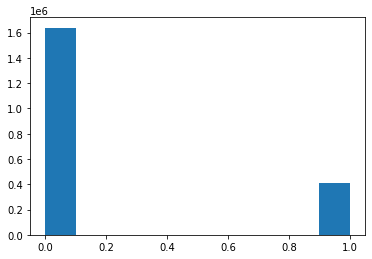

In [11]:
plt.hist(y_pred[0].flatten())

In [12]:
def create_mask(pred):

    pred_mask = tf.argmax(pred, axis=-1)
    pred_mask = tf.one_hot(pred_mask, 5)

    return pred_mask.numpy()

In [13]:
pred_mask = create_mask(y_pred)

In [14]:
np.min(pred_mask[0]), np.max(pred_mask[0])

(0.0, 1.0)

In [15]:
pred_mask.shape

(8, 256, 1600, 5)

In [17]:
sample[0][1].shape

(8, 256, 1600, 5)

In [18]:
sample[0][1][0][..., 3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
pred_mask[0][..., 3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

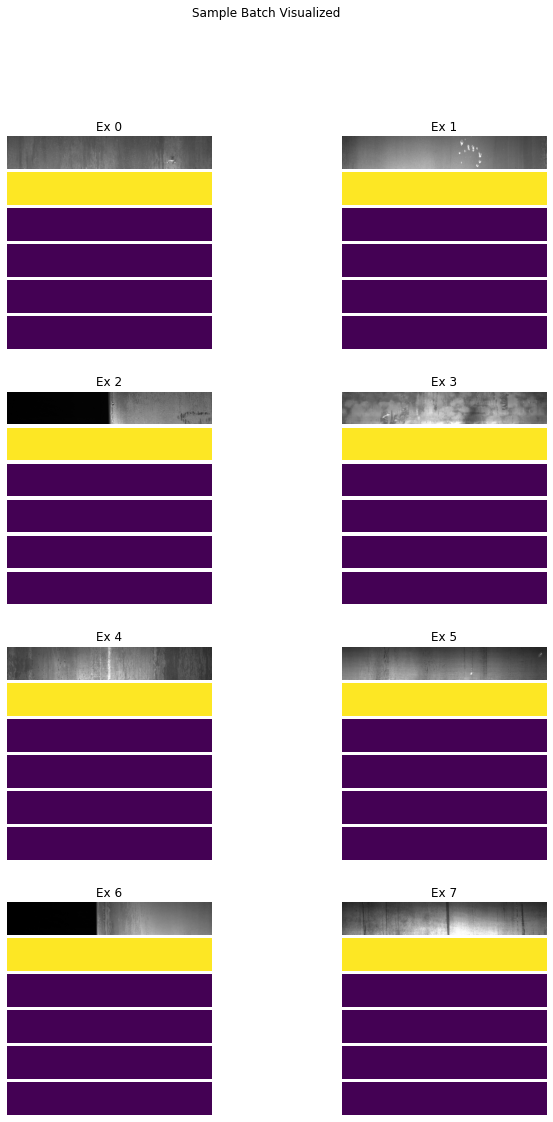

In [20]:
# with categorical cross-entropy loss | quick overfitting
plot_sample_batch([(sample[0][0], pred_mask)])

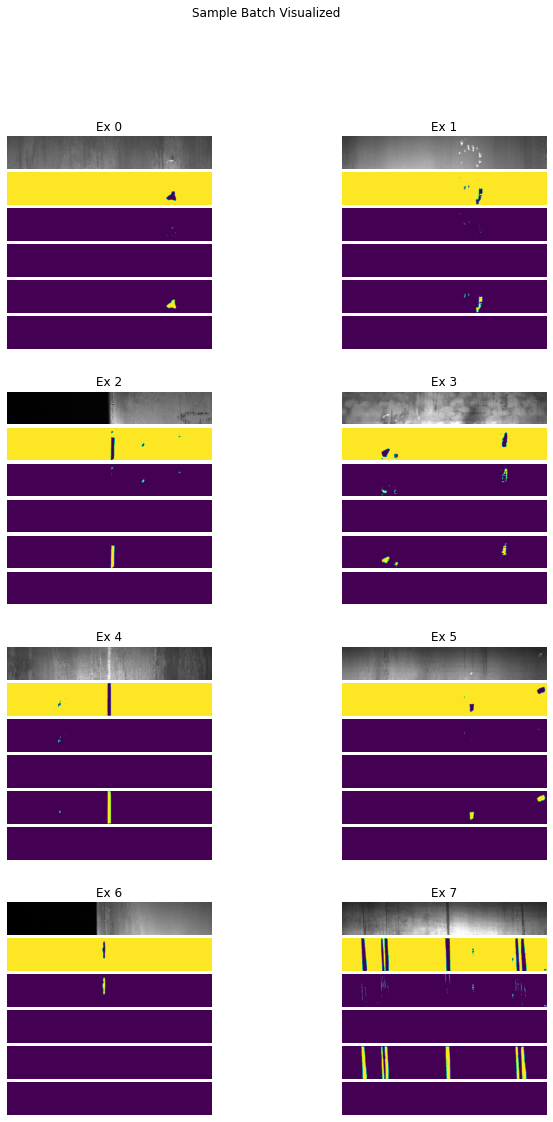

In [203]:
# with categorical cross-entropy loss | quick overfitting
plot_sample_batch([(sample[0][0], pred_mask)])

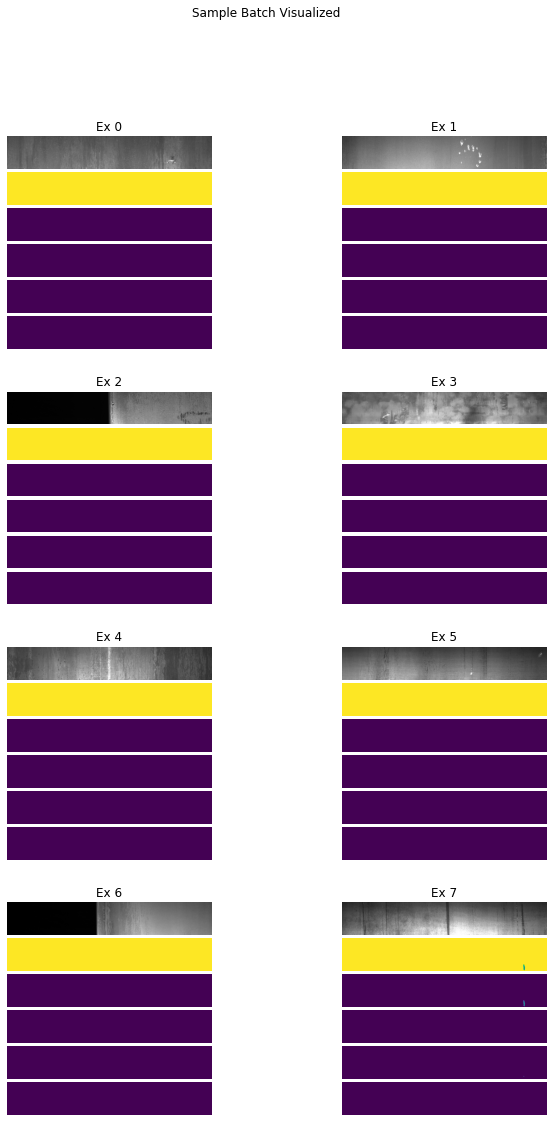

In [159]:
# with categorical cross-entropy loss | quick overfitting
plot_sample_batch([(sample[0][0], pred_mask)])

## Step through loss calculation

In [32]:
def dice_coeff(y_true, y_pred, epsilon=1e-6):
    """
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.

    Args:
        y_true: b x X x Y x c One hot encoding of ground truth
        y_pred: b x X x Y x c Network output, must sum to 1 over c channel (such as after softmax)
        epsilon: Used for numerical stability to avoid divide by zero errors
    """
    axes = tuple(range(1, 3))
    numerator = 2.0 * tf.reduce_sum((y_pred * y_true), axis=axes)
    denominator = tf.reduce_sum(y_pred + y_true, axis=axes)

    return tf.reduce_mean((numerator + epsilon) / (denominator + epsilon))

In [204]:
def dice_coeff(y_true, y_pred):
    smooth = 1.0
    y_true_f = layers.Flatten()(y_true)
    y_pred_f = layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2.0 * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )
    return score

In [205]:
x = sample[0][0]
y_true = sample[0][1]

In [206]:
x.shape, y_true.shape

((8, 256, 1600, 3), (8, 256, 1600, 5))

In [207]:
y_pred[0].shape, y_true[0].shape

((256, 1600, 5), (256, 1600, 5))

In [35]:
dice_coeff(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.070867874>

#### Simple Mask

In [216]:
# ground truth mask
y_true = np.zeros((2, 3, 3, 4))
y_true[0][1][1][0] = 1.0  # set middle point equal 1

# prediction mask
y_pred = np.zeros((2, 3, 3, 4))
y_pred[0][1][1][0] = 0.91
y_pred[0][1][2][0] = 0.7

In [217]:
y_true

array([[[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]],


       [[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]]])

In [218]:
y_pred

array([[[[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.91, 0.  , 0.  , 0.  ],
         [0.7 , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]]],


       [[[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]]]])

In [211]:
dice_coeff(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.78116345>

In [212]:
smooth = 1.0
y_true_f = layers.Flatten()(y_true)
y_pred_f = layers.Flatten()(y_pred)
intersection = tf.reduce_sum(y_true_f * y_pred_f)
numerator = 2.0 * intersection + smooth

denominator = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth

In [214]:
numerator

<tf.Tensor: shape=(), dtype=float32, numpy=2.8200002>

In [215]:
denominator

<tf.Tensor: shape=(), dtype=float32, numpy=3.6100001>

In [213]:
numerator / denominator

<tf.Tensor: shape=(), dtype=float32, numpy=0.78116345>

In [96]:
epsilon = 1e-6
axes = tuple(range(1, 3))  # (1, 2)

# pixel-wise multiply to cancel out
# then, get sum total of predicted probabilities in each channel
# then double
numerator = 2.0 * tf.reduce_sum((y_pred * y_true), axis=axes)

# pixel wise addition
# then, get sum total of
denominator = tf.reduce_sum(y_pred, axis=axes) + tf.reduce_sum(y_true, axis=axes)

In [97]:
numerator

<tf.Tensor: shape=(2, 4), dtype=float64, numpy=
array([[1.82, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ]])>

In [98]:
denominator

<tf.Tensor: shape=(2, 4), dtype=float64, numpy=
array([[2.61, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ]])>

In [101]:
# then average over channels
(numerator + epsilon) / (denominator + epsilon)

<tf.Tensor: shape=(2, 4), dtype=float64, numpy=
array([[0.69731812, 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        ]])>

In [102]:
tf.reduce_mean((numerator + epsilon) / (denominator + epsilon))

<tf.Tensor: shape=(), dtype=float64, numpy=0.9621647654541128>

In [138]:
tuple(range(1, len(y_pred.shape) - 1))

(1, 2)

In [139]:
len(y_pred.shape) - 1

3

In [150]:
epsilon = 1e-6
axes = tuple(range(1, 3))
numerator = 2.0 * tf.reduce_sum((y_pred * y_true), axis=axes)
denominator = tf.reduce_sum(y_pred + y_true, axis=axes)
loss = 1 - tf.reduce_mean((numerator + epsilon) / (denominator + epsilon))

In [144]:
denominator.shape

TensorShape([2, 4])

In [145]:
numerator

<tf.Tensor: shape=(2, 4), dtype=float64, numpy=
array([[1.82, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ]])>

In [146]:
denominator

<tf.Tensor: shape=(2, 4), dtype=float64, numpy=
array([[1.91, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ]])>

In [151]:
(numerator + epsilon) / (denominator + epsilon)

<tf.Tensor: shape=(2, 4), dtype=float64, numpy=
array([[0.95287961, 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        ]])>

In [152]:
tf.reduce_mean((numerator + epsilon) / (denominator + epsilon))

<tf.Tensor: shape=(), dtype=float64, numpy=0.9941099507277744>

In [156]:
def dice_coeff(y_true, y_pred, epsilon=1e-6):
    """
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.

    Args:
        y_true: b x X x Y x c One hot encoding of ground truth
        y_pred: b x X x Y x c Network output, must sum to 1 over c channel (such as after softmax)
        epsilon: Used for numerical stability to avoid divide by zero errors
    """
    axes = tuple(range(1, 3))
    numerator = 2.0 * tf.reduce_sum((y_pred * y_true), axis=axes)
    denominator = tf.reduce_sum(y_pred + y_true, axis=axes)

    return tf.reduce_mean((numerator + epsilon) / (denominator + epsilon))


def dice_loss(y_true, y_pred, epsilon=1e-6):
    return 1 - dice_coeff(y_true, y_pred, epsilon)

In [157]:
dice_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.005890049272225584>

In [125]:
y_pred.shape

(2, 3, 3, 4)

In [126]:
y_pred

array([[[[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.91, 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]]],


       [[[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]]]])

In [127]:
y_true

array([[[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]],


       [[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]]])

In [128]:
y_pred + y_true

array([[[[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [1.91, 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]]],


       [[[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  ]]]])

In [129]:
tf.reduce_sum(y_pred + y_true, axis=axes)

<tf.Tensor: shape=(2, 4), dtype=float64, numpy=
array([[1.91, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ]])>

In [ ]:
def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = layers.Flatten()(y_true)
    y_pred_f = layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [27]:
loss = tf.keras.losses.binary_crossentropy(y_true, y_true)
loss.numpy().sum()

0.0

In [24]:
loss = tf.keras.metrics.categorical_crossentropy(
    y_true, y_true, from_logits=True, axis=3
)

In [ ]:
loss.numpy().sum()

In [13]:
loss

<tf.Tensor: shape=(2, 256, 1600), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [64]:
loss.numpy().sum()

2365.6094

In [68]:
ex0_pred_defect_channel = ex0_pred[..., 2]

plt.hist(ex0_pred_defect_channel.flatten())

In [ ]:
tf.

(array([2.60000e+01, 3.81000e+02, 4.33030e+04, 2.47411e+05, 5.88913e+05,
        5.73011e+05, 1.72591e+05, 1.24820e+04, 2.55000e+02, 2.70000e+01]),
 array([0.2185303 , 0.224991  , 0.23145169, 0.23791237, 0.24437307,
        0.25083375, 0.25729445, 0.26375514, 0.27021584, 0.27667654,
        0.28313723], dtype=float32),
 <BarContainer object of 10 artists>)

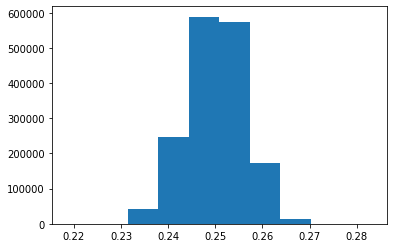

In [51]:
plt.hist(pred[0].flatten())

(array([2.23000e+02, 9.54600e+03, 1.17539e+05, 2.77109e+05, 6.87516e+05,
        3.91100e+05, 1.32182e+05, 2.19480e+04, 1.16000e+03, 7.70000e+01]),
 array([0.21749617, 0.22453664, 0.2315771 , 0.23861757, 0.24565804,
        0.2526985 , 0.25973898, 0.26677942, 0.2738199 , 0.28086036,
        0.28790084], dtype=float32),
 <BarContainer object of 10 artists>)

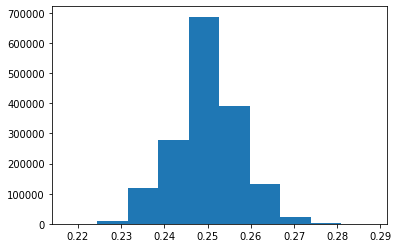

In [50]:
plt.hist(pred[1].flatten())

In [50]:
def create_mask(pred):

    pred_mask = tf.argmax(pred, axis=-1)
    pred_mask = tf.one_hot(pred_mask, 4)

    return pred_mask.numpy()

In [51]:
pred_mask = create_mask(pred)

In [52]:
np.min(pred_mask[0]), np.max(pred_mask[0])

(0.0, 1.0)

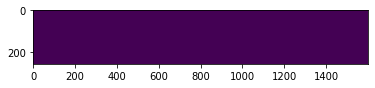

In [53]:
plt.imshow(pred_mask[0][..., 0])

In [54]:
np.unique(pred_mask)

array([0., 1.], dtype=float32)

(array([     0.,      0.,      0.,      0.,      0., 409600.,      0.,
             0.,      0.,      0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

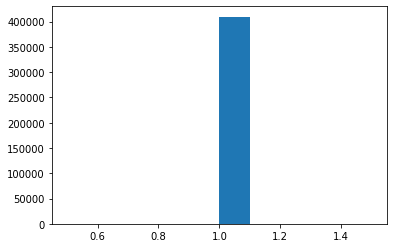

In [55]:
flat = pred_mask[0][..., 0].flatten()
plt.hist(flat)

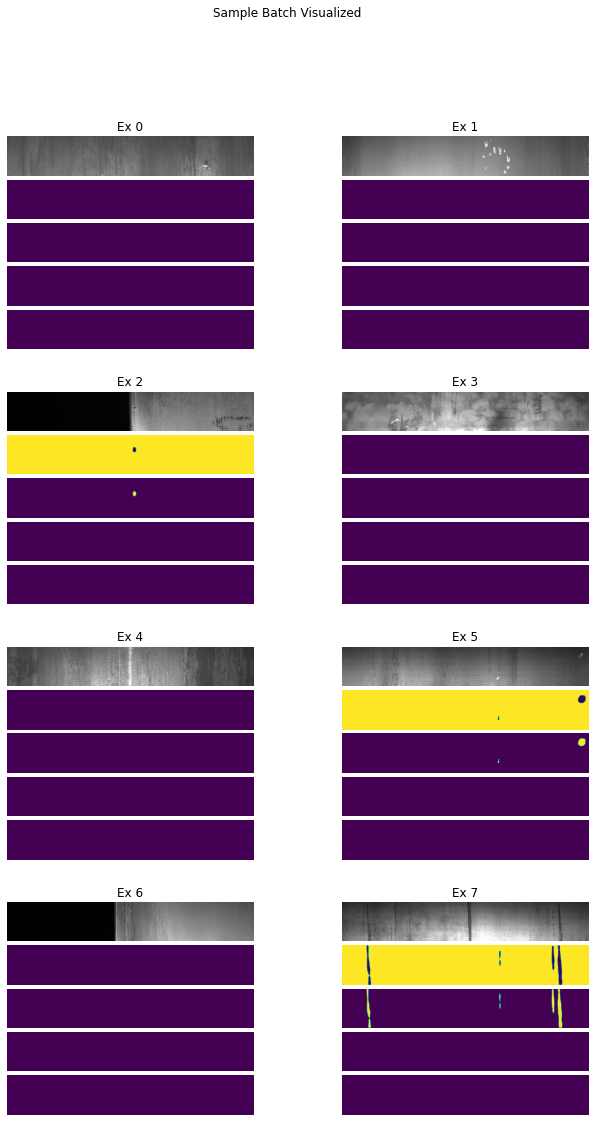

In [56]:
# with categorical cross-entropy loss | quick overfitting
plot_sample_batch([(sample[0][0], pred_mask)])

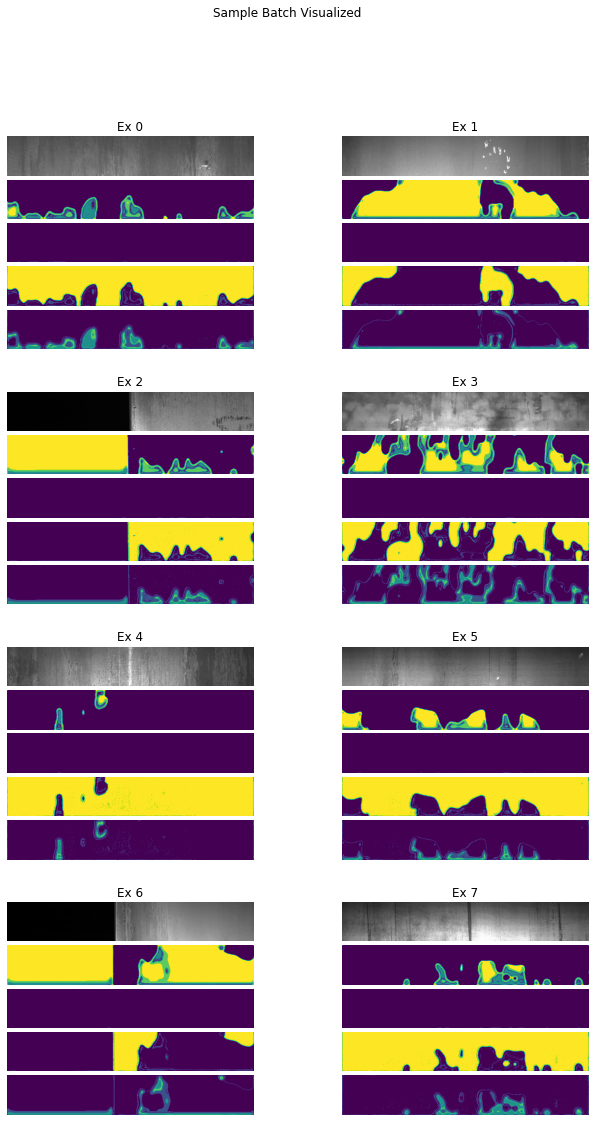

In [17]:
# with categorical cross-entropy loss | overnight
plot_sample_batch([(sample[0][0], pred_mask)])

**When I overfit on a single example, I would expect the probability distribution for a given channel to be extremely skewed...**

In [ ]:
ex0_pred = pred[0]
ex0_pred.shape

In [ ]:
test_softmax = tf.nn.softmax(ex0_pred, axis=-1)

In [ ]:
test_softmax.shape

In [ ]:
test_softmax[0, 0].numpy()

In [ ]:
plt.figure(figsize=(12, 8))
for channel in range(4):
    plt.hist(ex0_pred[..., channel].flatten(), bins=50, alpha=0.7)